# Instructions


In [ ]:
'''

# Assignment
2.2 Collaborative Filtering
In class, we have discussed matrix factorization methods for collaborative filtering. In this project, you will test this class of approaches and, if time permits, compare it to other methodologies.
Tasks:
1. Implement a collaborative filtering algorithm (from scratch) on the MovieLens 1M Dataset available here.
2. For evaluating your method, you will use a random training set containing 90% of the available ratings and
will report the Root Mean Squared Error (RMSE) on the remaining 10%.
3. You are encouraged to try several approaches and read the relevant recent literature on the problem.
'''

'\n\n# Assignment\n2.2 Collaborative Filtering\nIn class, we have discussed matrix factorization methods for collaborative filtering. In this project, you will test this class of approaches and, if time permits, compare it to other methodologies.\nTasks:\n1. Implement a collaborative filtering algorithm (from scratch) on the MovieLens 1M Dataset available here.\n2. For evaluating your method, you will use a random training set containing 90% of the available ratings and\nwill report the Root Mean Squared Error (RMSE) on the remaining 10%.\n3. You are encouraged to try several approaches and read the relevant recent literature on the problem.\n'

Group Number: 44

Filename: assignment_2_44.ipynb 

Group Member 1: Beh Ruey Yan, A0236004W 

Group Member 2: Shan Shenghao, A0116327L

Group Member 3: Wu Qiming, A0236022W 

Group Member 4: Hu Qisheng, A0235960B 

https://files.grouplens.org/datasets/movielens/ml-1m.zip

# First time setup
#### Place "ml-1m.zip" under "/content/drive/MyDrive/datasets/ml-1m/"
#### Run below to unzip

In [ ]:
# start from fresh and unmount any drive that was mounted before
# sometimes take a bit of time
from google.colab import drive
drive.flush_and_unmount()
drive.mount("/content/drive")
!unzip /content/drive/MyDrive/datasets/ml-1m/ml-1m.zip  -d  /content/drive/MyDrive/datasets/ml-1m

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


# Load lm-1m on a Google Colab


In [1]:
import os
import sys
import pandas as pd
import time
import matplotlib.pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp
from sklearn import metrics
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from tqdm.notebook import tqdm_notebook
import seaborn as sns
import sklearn.preprocessing
from jax import random
from scipy.sparse import csr_matrix
np.random.seed(42)
key = random.PRNGKey(42)

In [2]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount("/content/drive")

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/datasets/ml-1m/

/content/drive/MyDrive/datasets/ml-1m


In [4]:
users = pd.read_csv("/content/drive/MyDrive/datasets/ml-1m/ml-1m/users.dat",delimiter="::",header=None, names=["UserID", "Gender", "Age", "Occupation", "Zip-code"])

movies = pd.read_csv("/content/drive/MyDrive/datasets/ml-1m/ml-1m/movies.dat",delimiter="::",header=None, names=["MovieID", "Title", "Genres"],encoding='ISO-8859-1')

ratings = pd.read_csv("/content/drive/MyDrive/datasets/ml-1m/ml-1m/ratings.dat",delimiter="::",header=None, names=["UserID","MovieID","Rating","Timestamp"])

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


In [5]:
# Merge two datasets to have better picture
df = pd.merge(ratings, movies, on="MovieID")
df.head()

,UserID,MovieID,Rating,Timestamp,Title,Genres
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),Drama
1,2,1193,5,978298413,One Flew Over the Cuckoo's Nest (1975),Drama
2,12,1193,4,978220179,One Flew Over the Cuckoo's Nest (1975),Drama
3,15,1193,4,978199279,One Flew Over the Cuckoo's Nest (1975),Drama
4,17,1193,5,978158471,One Flew Over the Cuckoo's Nest (1975),Drama


In [6]:
# Create a dataset to explore
eda_rating = pd.DataFrame(df.groupby('Title')['Rating'].mean())

In [7]:
# Add number of ratings to the dataset
eda_rating['count of ratings'] = pd.DataFrame(df.groupby('Title')['Rating'].count())

In [8]:
# Top 10 most rated movies in our dataset
eda_rating.sort_values('count of ratings', ascending=False).head(10)

,Rating,count of ratings
Title,,
American Beauty (1999),4.317386,3428
Star Wars: Episode IV - A New Hope (1977),4.453694,2991
Star Wars: Episode V - The Empire Strikes Back (1980),4.292977,2990
Star Wars: Episode VI - Return of the Jedi (1983),4.022893,2883
Jurassic Park (1993),3.763847,2672
Saving Private Ryan (1998),4.337354,2653
Terminator 2: Judgment Day (1991),4.058513,2649
"Matrix, The (1999)",4.315830,2590
Back to the Future (1985),3.990321,2583


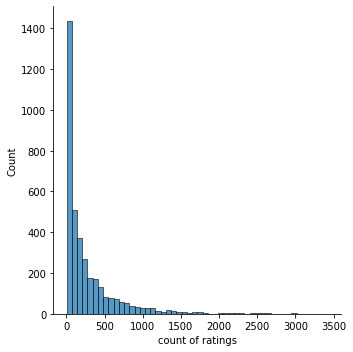

In [9]:
# Check the ratings count distribution in our dataset
sns.displot(data=eda_rating, x='count of ratings', bins=50)

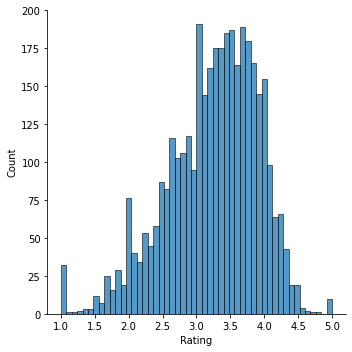

In [10]:
# How do peaple rate movies?
sns.displot(data=eda_rating, x='Rating', bins=50)

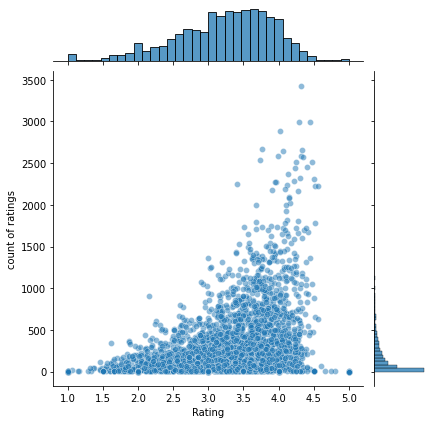

In [11]:
# Overview in one picture
sns.jointplot(x='Rating',y='count of ratings',data=eda_rating,alpha=0.5)

In [12]:
users.head()

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [13]:
users_count = users['UserID'].max()
users_count

6040

In [14]:
movies.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [15]:
movies_count = movies['MovieID'].max()
movies_count

3952

In [16]:
ratings.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


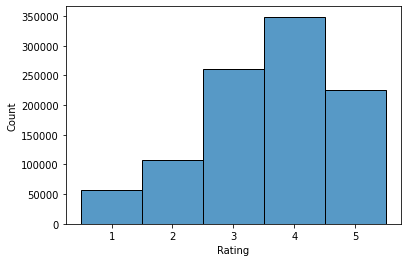

In [17]:
sns.histplot(data=ratings,x='Rating',discrete=True,)

In [18]:
ratings_df = pd.DataFrame(ratings.pivot(index = 'UserID', columns ='MovieID', values = 'Rating'))
ratings_df.head()

MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
UserID,,,,,,,,,,,,,,,,,,,,,
1,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
# sparsity
sparsity = sum(ratings_df.isnull())/len(ratings_df.index)/len(ratings_df.columns)
print('{:.2f}%'.format(sparsity*100))

33.04%


In [20]:
test_ratio = 0.1
test_indices = np.random.choice(len(ratings), int((test_ratio) * len(ratings)),replace=False).tolist()
train_indices = list(set(np.arange(len(ratings))).difference(set(test_indices)))

ratings_train = pd.DataFrame(ratings.loc[train_indices].pivot(index = 'UserID', columns ='MovieID', values = 'Rating'))
ratings_train = ratings_train.reindex(index=np.arange(1,1+users_count), columns=np.arange(1,1+movies_count))

ratings_test = pd.DataFrame(ratings.loc[test_indices].pivot(index = 'UserID', columns ='MovieID', values = 'Rating'))
ratings_test = ratings_test.reindex(index=np.arange(1,1+users_count), columns=np.arange(1,1+movies_count))
ratings_test = jnp.array(ratings_test)

In [21]:
print(len(train_indices),len(test_indices))
print(ratings_train.shape,ratings_test.shape)

900189 100020
(6040, 3952) (6040, 3952)


In [22]:
ratings_train

MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
UserID,,,,,,,,,,,,,,,,,,,,,
1,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6038,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
ratings_test

DeviceArray([[nan, nan, nan, ..., nan, nan, nan],
             [nan, nan, nan, ..., nan, nan, nan],
             [nan, nan, nan, ..., nan, nan, nan],
             ...,
             [nan, nan, nan, ..., nan, nan, nan],
             [nan, nan, nan, ..., nan, nan, nan],
             [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

In [24]:
@jax.jit
def RMSE(A_test,A_pred):
    error = A_test - A_pred
    return jnp.sqrt(jnp.nanmean(error**2))

def RMSE_int(A_test,A_pred):
    # round off predicted value and discretize
    A_pred = jnp.round(A_pred)
    A_pred = jnp.array(np.vectorize(lambda x: 5 if x>5 else 1 if x<1 else x)(A_pred))
    error = A_test - A_pred
    return jnp.sqrt(jnp.nanmean(error**2))

# Naive models

### Global mean

In [25]:
global_mean = np.nanmean(ratings_train)
global_mean

3.5814467850640255

In [26]:
ratings_pred_global_mean = jnp.array(ratings_train.fillna(global_mean))
RMSE(ratings_test,ratings_pred_global_mean)

DeviceArray(1.116474, dtype=float32)

In [27]:
RMSE_int(ratings_test,ratings_pred_global_mean)

DeviceArray(1.1919379, dtype=float32)

### Movie mean

In [28]:
movie_mean = ratings_train.mean(axis=0)
movie_mean

MovieID
1       4.141626
2       3.212121
3       3.018182
4       2.712329
5       3.021505
          ...   
3948    3.618490
3949    4.132353
3950    3.659574
3951    3.972973
3952    3.782857
Length: 3952, dtype: float64

In [ ]:
movie_mean.describe()

count    3694.000000
mean        3.240894
std         0.675277
min         1.000000
25%         2.821798
50%         3.333333
75%         3.741935
max         5.000000
dtype: float64

In [ ]:
ratings_pred_movie_mean = jnp.array(ratings_train.fillna(movie_mean).fillna(global_mean))
RMSE(ratings_test,ratings_pred_movie_mean)

DeviceArray(0.9809749, dtype=float32)

In [ ]:
RMSE_int(ratings_test,ratings_pred_movie_mean)

DeviceArray(1.0211473, dtype=float32)

### User mean

In [ ]:
user_mean = ratings_train.mean(axis=1)
user_mean

UserID
1       4.133333
2       3.677966
3       3.893617
4       4.250000
5       3.164773
          ...   
6036    3.313222
6037    3.688525
6038    3.937500
6039    3.893805
6040    3.573290
Length: 6040, dtype: float64

In [ ]:
user_mean.describe()

count    6040.000000
mean        3.703766
std         0.432982
min         1.017544
25%         3.441396
50%         3.740741
75%         4.000000
max         4.956522
dtype: float64

In [ ]:
ratings_pred_user_mean = jnp.array(ratings_train.fillna(user_mean).fillna(global_mean))
RMSE(ratings_test,ratings_pred_user_mean)

DeviceArray(1.199763, dtype=float32)

In [ ]:
RMSE_int(ratings_test,ratings_pred_user_mean)

DeviceArray(1.230905, dtype=float32)

### 1. User weighted mean
$\displaystyle\hat{R}_{u,f}=\frac{1}{\alpha+|F(u)|}\left(\alpha M+\sum_{f\in{F(u)}}{R_{u,f}}\right)$

In [ ]:
def user_weighted_mean(alpha,ratings_train=ratings_train):
  return (alpha * global_mean + ratings_train.sum(axis=1)) / (alpha + ratings_train.notnull().sum(axis=1))

In [ ]:
alpha = np.arange(0,1001,100)
user_weighted_rmse = [RMSE(ratings_test,jnp.array(ratings_train.fillna(user_weighted_mean(i)))) for i in alpha]

Text(0.5, 1.0, 'user weighted mean')

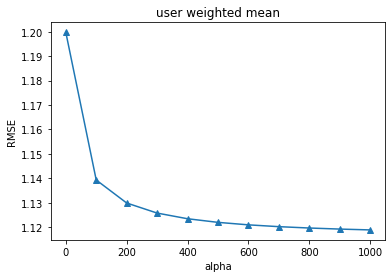

In [ ]:
plt.plot(alpha,user_weighted_rmse,'-^')
plt.xlabel('alpha')
plt.ylabel('RMSE')
plt.title('user weighted mean')

## 2. Matrix factorization

In [ ]:
A = jnp.array(ratings_train)
A

DeviceArray([[ 5., nan, nan, ..., nan, nan, nan],
             [nan, nan, nan, ..., nan, nan, nan],
             [nan, nan, nan, ..., nan, nan, nan],
             ...,
             [nan, nan, nan, ..., nan, nan, nan],
             [nan, nan, nan, ..., nan, nan, nan],
             [ 3., nan, nan, ..., nan, nan, nan]], dtype=float32)

In [ ]:
def l2_loss(x, alpha):
    return alpha * jnp.mean(jnp.square(x))

@jax.jit
def MSE(U,V,A):
    error = A - U @ V
    error = jnp.nan_to_num(error,nan=0.)
    return jnp.mean(error**2)

@jax.jit
def MSE_regularized(U, V, A, alpha):
    error = A - U @ V
    error = jnp.nan_to_num(error,nan=0.)
    return jnp.mean(error**2) + l2_loss(U, alpha) + l2_loss(V, alpha)

# MSE_grad_u = jax.jit( jax.grad(MSE, argnums=0) )
# MSE_grad_v = jax.jit( jax.grad(MSE, argnums=1) )

In [ ]:
def train_model(A, r=10, niter=100, learning_rate=1.0, alpha=0.001, mode='default'):
  '''
  A: training matrix
  r: factorization dimension
  niter: number of iterations
  learning_rate: learning rate 
  mode: 'default'/'regularized'/'residual'
  '''
  m,n = A.shape
  U_init = np.random.normal(0,1,size=(m,r))
  V_init = np.random.normal(0,1,size=(r,n))
  MSE_grad_u = None
  MSE_grad_v = None
  grad_u = None
  grad_v = None

  if mode == 'default':
    MSE_grad_u = jax.jit( jax.grad(MSE, argnums=0) )
    MSE_grad_v = jax.jit( jax.grad(MSE, argnums=1) )
    grad_u = MSE_grad_u(U_init,V_init,A)
    grad_v = MSE_grad_v(U_init,V_init,A)
  elif mode == 'regularized':
    MSE_grad_u = jax.jit( jax.grad(MSE_regularized, argnums=0) )
    MSE_grad_v = jax.jit( jax.grad(MSE_regularized, argnums=1) )
    grad_u = MSE_grad_u(U_init,V_init,A, alpha)
    grad_v = MSE_grad_v(U_init,V_init,A, alpha)

  U,V = np.copy(U_init), np.copy(V_init)

  loss_history = []

  for _ in range(niter):
      # compute the gradients
      if mode == 'default':
        grad_u = MSE_grad_u(U, V, A)
        grad_v = MSE_grad_v(U, V, A)
      elif mode == 'regularized':
        grad_u = MSE_grad_u(U, V, A, alpha)
        grad_v = MSE_grad_v(U, V, A, alpha)
      
      # do the gradient updates
      U = U - learning_rate * grad_u
      V = V - learning_rate * grad_v
      
      # check the loss for monitoring purposes
      current_loss = MSE(U,V,A)
      loss_history.append(current_loss)

  plt.plot(loss_history, "-^")

  return U,V


def evaluate_model(U,V):
  print("{:20}".format("Train RMSE:"), "{:.3f}".format(RMSE(jnp.array(ratings_train),U@V)))
  print("{:20}".format("Train RMSE roundoff:"), "{:.3f}".format(RMSE_int(jnp.array(ratings_train),U@V)))
  print("{:20}".format("Test RMSE:"), "{:.3f}".format(RMSE(ratings_test,U@V)))
  print("{:20}".format("Test RMSE roundoff:"), "{:.3f}".format(RMSE_int(ratings_test,U@V)))

  return


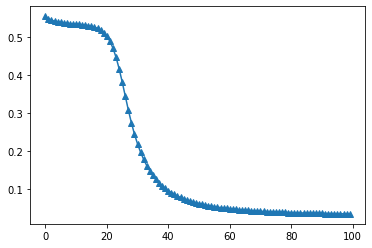

In [ ]:
U,V = train_model(A, r=1, niter=100, learning_rate=2000.0, mode='default')

In [ ]:
evaluate_model(U,V)

Train RMSE:          0.961
Train RMSE roundoff: 0.992
Test RMSE:           0.976
Test RMSE roundoff:  1.006


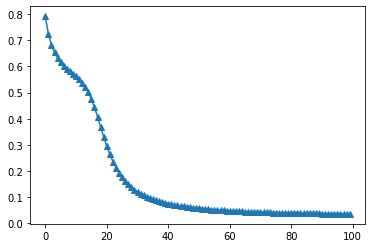

In [ ]:
U,V = train_model(A, r=10, niter=100, learning_rate=2000.0, mode='default')

In [ ]:
evaluate_model(U,V)

Train RMSE:          0.983
Train RMSE roundoff: 1.006
Test RMSE:           1.064
Test RMSE roundoff:  1.058


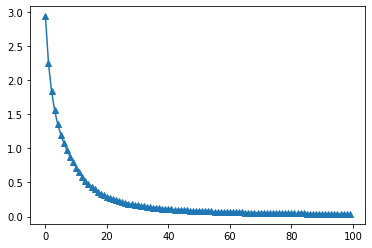

In [ ]:
U,V = train_model(A, r=100, niter=100, learning_rate=2000.0, mode='default')

In [ ]:
evaluate_model(U,V)

Train RMSE:          1.015
Train RMSE roundoff: 1.008
Test RMSE:           2.616
Test RMSE roundoff:  1.450


------------------------------------------
Low-rank dimension reduction r=1
Train RMSE:          0.950
Train RMSE roundoff: 0.984
Test RMSE:           0.964
Test RMSE roundoff:  0.995
------------------------------------------
Low-rank dimension reduction r=5
Train RMSE:          0.968
Train RMSE roundoff: 0.996
Test RMSE:           1.008
Test RMSE roundoff:  1.028
------------------------------------------
Low-rank dimension reduction r=10
Train RMSE:          0.982
Train RMSE roundoff: 1.005
Test RMSE:           1.063
Test RMSE roundoff:  1.060
------------------------------------------
Low-rank dimension reduction r=20
Train RMSE:          1.006
Train RMSE roundoff: 1.018
Test RMSE:           1.201
Test RMSE roundoff:  1.121
------------------------------------------
Low-rank dimension reduction r=50
Train RMSE:          1.029
Train RMSE roundoff: 1.028
Test RMSE:           1.661
Test RMSE roundoff:  1.261
------------------------------------------
Low-rank dimension reduction r=100

,RMSE
r,
1,0.9636647
5,1.0081538
10,1.0626085
20,1.2010473
50,1.6609241
100,2.6207042
500,11.724268
1000,22.438292


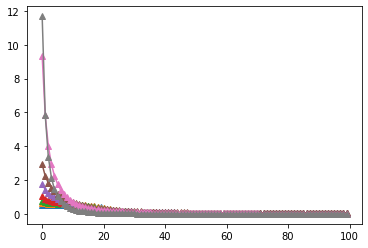

In [ ]:
mf_RSME=[]
r_value=[1,5,10,20, 50,100,500,1000]
for i in r_value:
  U,V = train_model(A, r=i, niter=100, learning_rate=2000.0, mode='default')
  rsme=RMSE(ratings_test,U@V)
  mf_RSME.append(rsme)
  print('------------------------------------------')
  print(f'Low-rank dimension reduction r={i}')
  evaluate_model(U,V)
data_tuples = list(zip(r_value,mf_RSME))
mf=pd.DataFrame(data_tuples, columns=['r','RMSE']).set_index('r')
mf

------------------------------------------
learning rate=0.5
Train RMSE:          3.877
Train RMSE roundoff: 2.766
Test RMSE:           3.876
Test RMSE roundoff:  2.767
------------------------------------------
learning rate=5
Train RMSE:          3.865
Train RMSE roundoff: 2.773
Test RMSE:           3.869
Test RMSE roundoff:  2.774
------------------------------------------
learning rate=10
Train RMSE:          3.869
Train RMSE roundoff: 2.770
Test RMSE:           3.870
Test RMSE roundoff:  2.770
------------------------------------------
learning rate=50
Train RMSE:          3.819
Train RMSE roundoff: 2.791
Test RMSE:           3.822
Test RMSE roundoff:  2.791
------------------------------------------
learning rate=100
Train RMSE:          3.792
Train RMSE roundoff: 2.800
Test RMSE:           3.798
Test RMSE roundoff:  2.802
------------------------------------------
learning rate=500
Train RMSE:          3.562
Train RMSE roundoff: 2.789
Test RMSE:           3.567
Test RMSE roundof

,RMSE
Learning rate,
0.5,3.8755896
5.0,3.8686168
10.0,3.8699646
50.0,3.8215692
100.0,3.797865
500.0,3.5665214
1000.0,1.218774
2000.0,0.97317874


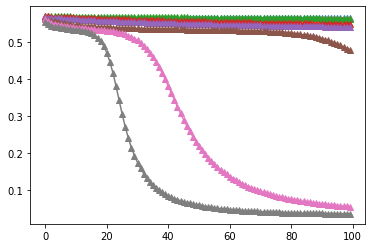

In [ ]:
mf_RSME=[]
learning_value=[0.5,5,10,50,100,500,1000,2000]
for i in learning_value:
  U,V = train_model(A, r=1, niter=100, learning_rate=i, mode='default')
  rsme=RMSE(ratings_test,U@V)
  mf_RSME.append(rsme)
  print('------------------------------------------')
  print(f'learning rate={i}')
  evaluate_model(U,V)
data_tuples = list(zip(learning_value,mf_RSME))
mf=pd.DataFrame(data_tuples, columns=['Learning rate','RMSE']).set_index('Learning rate')
mf

------------------------------------------
learning rate=0.5
Train RMSE:          3.881
Train RMSE roundoff: 2.765
Test RMSE:           3.886
Test RMSE roundoff:  2.765
------------------------------------------
learning rate=1000
Train RMSE:          1.198
Train RMSE roundoff: 1.176
Test RMSE:           1.218
Test RMSE roundoff:  1.188
------------------------------------------
learning rate=2000
Train RMSE:          0.955
Train RMSE roundoff: 0.989
Test RMSE:           0.969
Test RMSE roundoff:  1.002


,RMSE
Learning rate,
0.5,3.885721
1000.0,1.2181344
2000.0,0.9690794


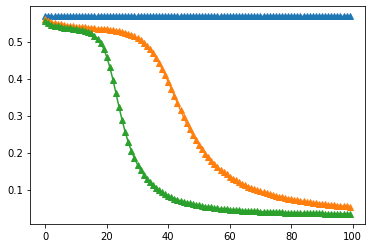

In [ ]:
mf_RSME=[]
learning_value=[0.5,1000,2000]
for i in learning_value:
  U,V = train_model(A, r=1, niter=100, learning_rate=i, mode='default')
  rsme=RMSE(ratings_test,U@V)
  mf_RSME.append(rsme)
  print('------------------------------------------')
  print(f'learning rate={i}')
  evaluate_model(U,V)
data_tuples = list(zip(learning_value,mf_RSME))
mf=pd.DataFrame(data_tuples, columns=['Learning rate','RMSE']).set_index('Learning rate')
mf

------------------------------------------
lambda_value=0.01
Train RMSE:          1.039
Train RMSE roundoff: 1.072
Test RMSE:           1.052
Test RMSE roundoff:  1.084
------------------------------------------
lambda_value=0.025
Train RMSE:          1.215
Train RMSE roundoff: 1.240
Test RMSE:           1.226
Test RMSE roundoff:  1.251
------------------------------------------
lambda_value=0.05
Train RMSE:          1.521
Train RMSE roundoff: 1.528
Test RMSE:           1.529
Test RMSE roundoff:  1.535
------------------------------------------
lambda_value=0.1
Train RMSE:          2.046
Train RMSE roundoff: 1.995
Test RMSE:           2.051
Test RMSE roundoff:  1.998
------------------------------------------
lambda_value=0.25
Train RMSE:          3.182
Train RMSE roundoff: 2.750
Test RMSE:           3.182
Test RMSE roundoff:  2.749
------------------------------------------
lambda_value=0.5
Train RMSE:          3.752
Train RMSE roundoff: 2.813
Test RMSE:           3.753
Test RMSE roun

,RMSE
lambda,
0.010,1.0523155
0.025,1.2263057
0.050,1.5294029
0.100,2.050508
0.250,3.1822584
0.500,3.7525597
1.000,3.7525597
1.500,3.7525597


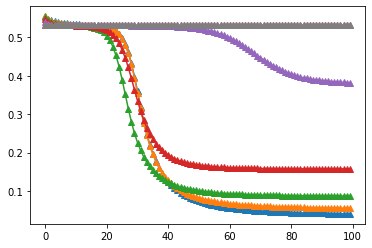

In [ ]:
mf_RSME=[]
lambda_value=[0.01,0.025,0.05,0.1,0.25,0.5,1,1.5]
for i in lambda_value:
  U,V = train_model(A, r=1, niter=100, learning_rate=2000, alpha=i, mode='regularized')
  rsme=RMSE(ratings_test,U@V)
  mf_RSME.append(rsme)
  print('------------------------------------------')
  print(f'lambda_value={i}')
  evaluate_model(U,V)
data_tuples = list(zip(lambda_value,mf_RSME))
mf=pd.DataFrame(data_tuples, columns=['lambda','RMSE']).set_index('lambda')
mf

Train RMSE:          0.295
Train RMSE roundoff: 0.274
Test RMSE:           22.547
Test RMSE roundoff:  2.337


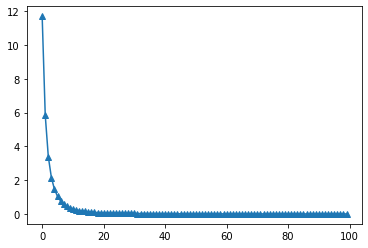

In [ ]:
U,V = train_model(A, r=1000, niter=100, learning_rate=2000.0, mode='default')
evaluate_model(U,V)

Train RMSE:          0.931
Train RMSE roundoff: 0.966
Test RMSE:           1.008
Test RMSE roundoff:  1.020


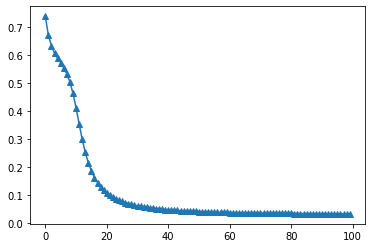

In [ ]:
U,V = train_model(A, r=10, niter=100, learning_rate=3000, mode='default')
evaluate_model(U,V)

# 3. User-based Collaborative Filtering
### Step 0. Preprocess the ratings data

In [ ]:
def load():
    ratings = pd.read_csv(
          'ml-1m/ratings.dat',
          sep='::',
          names=["userid", "itemid", "rating", "timestamp"],
          engine='python'
    )
    ratings = ratings.sort_values(by=['userid', 'itemid']).reset_index(drop=True)
    ratings = ratings.drop(columns=['timestamp'])

    movies = pd.read_csv(
          'ml-1m/movies.dat',
          sep='::',
          names=["itemid", "title", "genres"],
          encoding='latin-1',
          engine='python'
      )
      
    return ratings, movies

ratings, movies = load()

In [ ]:
def ids_encoder(ratings):
    users = sorted(ratings['userid'].unique())
    items = sorted(ratings['itemid'].unique())

    # create users and items encoders
    uencoder = LabelEncoder()
    iencoder = LabelEncoder()

    # fit users and items ids to the corresponding encoder
    uencoder.fit(users)
    iencoder.fit(items)

    # encode userids and itemids
    ratings.userid = uencoder.transform(ratings.userid.tolist())
    ratings.itemid = iencoder.transform(ratings.itemid.tolist())

    return ratings, uencoder, iencoder

In [ ]:
ratings

,userid,itemid,rating
0,1,1,5
1,1,48,5
2,1,150,5
3,1,260,4
4,1,527,5
...,...,...,...
1000204,6040,3683,4
1000205,6040,3703,4
1000206,6040,3735,4
1000207,6040,3751,4


In [ ]:
def ratings_matrix(ratings):    
    return csr_matrix(pd.crosstab(ratings.userid, ratings.itemid, ratings.rating, aggfunc=sum).fillna(0).values)

ratings, uencoder, iencoder = ids_encoder(ratings)
R = ratings_matrix(ratings)

### Step 1. Identify similar users

In [ ]:
def create_model(rating_matrix, metric):
    """
    - create the nearest neighbors model with the corresponding similarity metric
    - fit the model
    """
    model = NearestNeighbors(metric=metric, n_neighbors=21, algorithm='brute')
    model.fit(rating_matrix)    
    return model

def nearest_neighbors(rating_matrix, model):
    """    
    :param rating_matrix : rating matrix of shape (nb_users, nb_items)
    :param model : nearest neighbors model    
    :return
        - similarities : distances of the neighbors from the referenced user
        - neighbors : neighbors of the referenced user in decreasing order of similarities
    """    
    similarities, neighbors = model.kneighbors(rating_matrix)        
    return similarities[:, 1:], neighbors[:, 1:]

In [ ]:
model = create_model(rating_matrix=R, metric='cosine')
similarities, neighbors = nearest_neighbors(R, model)

### Step 2. Find candidate movies

In [ ]:
def find_candidate_items(userid):
    """
    Find candidate items for an active user
    
    :param userid : active user
    :param neighbors : users similar to the active user        
    :return candidates : top 30 of candidate items
    """
    user_neighbors = neighbors[userid]
    activities = ratings.loc[ratings.UserID.isin(user_neighbors)]
    
    # sort items in decreasing order of frequency
    frequency = activities.groupby('itemid')['rating'].count().reset_index(name='count').sort_values(['count'],ascending=False)
    Gu_items = frequency.itemid
    active_items = ratings.loc[ratings.userid == userid].itemid.to_list()
    candidates = np.setdiff1d(Gu_items, active_items, assume_unique=True)[:30]
        
    return candidates

### Step 3. Predict movie ratings

In [ ]:
# mean ratings for each user
mean = ratings.groupby(by='userid', as_index=False)['rating'].mean()
mean_ratings = pd.merge(ratings, mean, suffixes=('','_mean'), on='userid')

# normalized ratings for each items
mean_ratings['norm_rating'] = mean_ratings['rating'] - mean_ratings['rating_mean']

mean = mean.to_numpy()[:, 1]
np_ratings = mean_ratings.to_numpy()

In [ ]:
def predict(userid, itemid):
    """
    predict what score userid would have given to itemid.
    
    :param
        - userid : user id for which we want to make prediction
        - itemid : item id on which we want to make prediction
        
    :return
        - r_hat : predicted rating of user userid on item itemid
    """
    user_similarities = similarities[userid]
    user_neighbors = neighbors[userid]
    # get mean rating of user userid
    user_mean = mean[userid]
    
    # find users who rated item 'itemid'
    iratings = np_ratings[np_ratings[:, 1].astype('int') == itemid]
    
    # find similar users to 'userid' who rated item 'itemid'
    suri = iratings[np.isin(iratings[:, 0], user_neighbors)]
    
    # similar users who rated current item (surci)
    normalized_ratings = suri[:,4]
    indexes = [np.where(user_neighbors == uid)[0][0] for uid in suri[:, 0].astype('int')]
    sims = user_similarities[indexes]
    
    num = np.dot(normalized_ratings, sims)
    den = np.sum(np.abs(sims))
    
    if num == 0 or den == 0:
        return user_mean
    
    r_hat = user_mean + np.dot(normalized_ratings, sims) / np.sum(np.abs(sims))
    
    return r_hat

In [ ]:
from sklearn.model_selection import train_test_split as sklearn_train_test_split

def get_examples(dataframe, labels_column="rating"):
    examples = dataframe[['userid', 'itemid']].values
    labels = dataframe[f'{labels_column}'].values
    return examples, labels


def train_test_split(examples, labels, test_size=0.1, verbose=0):
    if verbose:
        print("Train/Test split ")
        print(100-test_size*100, "% of training data")
        print(test_size*100, "% of testing data")    

    # split data into train and test sets
    train_examples, test_examples, train_labels, test_labels = sklearn_train_test_split(
        examples, 
        labels, 
        test_size=0.1, 
        random_state=42, 
        shuffle=True
    )

    # transform train and test examples to their corresponding one-hot representations
    train_users = train_examples[:, 0]
    test_users = test_examples[:, 0]

    train_items = train_examples[:, 1]
    test_items = test_examples[:, 1]

    # Final training and test set
    x_train = np.array(list(zip(train_users, train_items)))
    x_test = np.array(list(zip(test_users, test_items)))

    y_train = train_labels
    y_test = test_labels

    if verbose:
        print()
        print('number of training examples : ', x_train.shape)
        print('number of training labels : ', y_train.shape)
        print('number of test examples : ', x_test.shape)
        print('number of test labels : ', y_test.shape)

    return (x_train, x_test), (y_train, y_test)

In [ ]:
# get examples as tuples of userids and itemids and labels from normalize ratings
raw_examples, raw_labels = get_examples(ratings, labels_column='rating')

# train test split
(x_train, x_test), (y_train, y_test) = train_test_split(examples=raw_examples, labels=raw_labels)

def evaluate(x_test, y_test):
    print('Evaluate the model on {} test data ...'.format(x_test.shape[0]))
    preds = list(predict(u,i) for (u,i) in x_test)
    rmse = mean_squared_error(y_test, preds, squared=False)
    print('\nRMSE:', rmse)
    return rmse

In [ ]:
# This may take a few minutes to run
evaluate(x_test, y_test)

Evaluate the model on 100021 test data ...

RMSE: 0.9430955911776768


0.9430955911776768

# 4. Item-based Collaborative Filtering

In [ ]:
# Load the dataset again
ratings, movies = load()

In [ ]:
ratings, uencoder, iencoder = ids_encoder(ratings)

### Step 1. Find similarities for each of the items

In [ ]:
def normalize():
    # compute mean rating for each user
    mean = ratings.groupby(by='userid', as_index=False)['rating'].mean()
    norm_ratings = pd.merge(ratings, mean, suffixes=('','_mean'), on='userid')
    
    # normalize each rating by substracting the mean rating of the corresponding user
    norm_ratings['norm_rating'] = norm_ratings['rating'] - norm_ratings['rating_mean']
    return mean.to_numpy()[:, 1], norm_ratings

In [ ]:
mean, norm_ratings = normalize()
np_ratings = norm_ratings.to_numpy()
norm_ratings.head()

,userid,itemid,rating,rating_mean,norm_rating
0,0,0,5,4.188679,0.811321
1,0,47,5,4.188679,0.811321
2,0,144,5,4.188679,0.811321
3,0,253,4,4.188679,-0.188679
4,0,513,5,4.188679,0.811321


In [ ]:
def item_representation(ratings):    
    return csr_matrix(pd.crosstab(ratings.itemid, ratings.userid, ratings.norm_rating, aggfunc=sum).fillna(0).values)

R = item_representation(norm_ratings)

In [ ]:
def create_model(rating_matrix, k=20, metric="cosine"):
    """
    :param R : numpy array of item representations
    :param k : number of nearest neighbors to return    
    :return model : our knn model
    """    
    model = NearestNeighbors(metric=metric, n_neighbors=k+1, algorithm='brute')
    model.fit(rating_matrix)    
    return model

def nearest_neighbors(rating_matrix, model):
    """
    compute the top n similar items for each item.    
    :param rating_matrix : items representations
    :param model : nearest neighbors model    
    :return similarities, neighbors
    """    
    similarities, neighbors = model.kneighbors(rating_matrix)    
    return similarities[:,1:], neighbors[:,1:]

In [ ]:
model = create_model(R, k=21, metric="cosine")
similarities, neighbors = nearest_neighbors(R, model)

In [ ]:
print('neighbors shape : ', neighbors.shape)
print('similarities shape : ', similarities.shape)

neighbors shape :  (3706, 21)
similarities shape :  (3706, 21)


Step 2. Predict movie ratings

In [ ]:
def predict(userid, itemid):
    """
    Make rating prediction for user userid on item itemid    
    :param userid : id of the active user
    :param itemid : id of the item for which we are making prediction        
    :return r_hat : predicted rating
    """
    
    # Get items similar to item itemid with their corresponding similarities
    item_neighbors = neighbors[itemid]
    item_similarities = similarities[itemid]
    
    # get ratings of user with id userid
    uratings = np_ratings[np_ratings[:, 0].astype('int') == userid]
    
    # similar items rated by item the user of i
    siru = uratings[np.isin(uratings[:, 1], item_neighbors)]
    scores = siru[:, 2]
    indexes = [np.where(item_neighbors == iid)[0][0] for iid in siru[:,1].astype('int')]    
    sims = item_similarities[indexes]
    
    dot = np.dot(scores, sims)
    som = np.sum(np.abs(sims))

    if dot == 0 or som == 0:
        return mean[userid]
    
    return dot / som

In [ ]:
# get examples as tuples of userids and itemids and labels from normalize ratings
raw_examples, raw_labels = get_examples(ratings, labels_column='rating')

# train test split
(x_train, x_test), (y_train, y_test) = train_test_split(examples=raw_examples, labels=raw_labels)

In [ ]:
def evaluate(x_test, y_test):
    print('Evaluate the model on {} test data ...'.format(x_test.shape[0]))
    preds = list(predict(u,i) for (u,i) in x_test)
    rmse = mean_squared_error(y_test, preds, squared=False)
    print('\nRMSE:', rmse)
    return rmse

In [ ]:
# This may take a few minutes to run
evaluate(x_test, y_test)

Evaluate the model on 100021 test data ...

RMSE: 0.8849379158906104


0.8849379158906104

# Item based CF (Parameter tuning)

##### Metric: cosine/euclidean; KNN: k

In [ ]:
from sklearn.model_selection import train_test_split as sklearn_train_test_split
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import csr_matrix

import numpy as np
import pandas as pd


def get_examples(dataframe, labels_column="rating"):
    examples = dataframe[['userid', 'itemid']].values
    labels = dataframe[f'{labels_column}'].values
    return examples, labels


def train_test_split(examples, labels, test_size=0.1, verbose=0):
    if verbose:
        print("Train/Test split ")
        print(100-test_size*100, "% of training data")
        print(test_size*100, "% of testing data")    

    # split data into train and test sets
    train_examples, test_examples, train_labels, test_labels = sklearn_train_test_split(
        examples, 
        labels, 
        test_size=0.1, 
        random_state=42, 
        shuffle=True
    )

    # transform train and test examples to their corresponding one-hot representations
    train_users = train_examples[:, 0]
    test_users = test_examples[:, 0]

    train_items = train_examples[:, 1]
    test_items = test_examples[:, 1]

    # Final training and test set
    x_train = np.array(list(zip(train_users, train_items)))
    x_test = np.array(list(zip(test_users, test_items)))

    y_train = train_labels
    y_test = test_labels

    if verbose:
        print()
        print('number of training examples : ', x_train.shape)
        print('number of training labels : ', y_train.shape)
        print('number of test examples : ', x_test.shape)
        print('number of test labels : ', y_test.shape)

    return (x_train, x_test), (y_train, y_test)


def mean_ratings(dataframe):
    means = dataframe.groupby(by='userid', as_index=False)['rating'].mean()
    return means


def normalized_ratings(dataframe, norm_column="norm_rating"):
    """
    Subscribe users mean ratings from each rating 
    """
    mean = mean_ratings(dataframe=dataframe)
    norm = pd.merge(dataframe, mean, suffixes=('', '_mean'), on='userid')
    norm[f'{norm_column}'] = norm['rating'] - norm['rating_mean']

    return norm


def rating_matrix(dataframe, column):
    crosstab = pd.crosstab(dataframe.userid, dataframe.itemid, dataframe[f'{column}'], aggfunc=sum).fillna(0).values
    matrix = csr_matrix(crosstab)
    return matrix


def scale_ratings(dataframe, scaled_column="scaled_rating"):
    dataframe[f"{scaled_column}"] = dataframe.rating / 5.0
    return dataframe


def ids_encoder(ratings):
    users = sorted(ratings['userid'].unique())
    items = sorted(ratings['itemid'].unique())

    # create users and items encoders
    uencoder = LabelEncoder()
    iencoder = LabelEncoder()

    # fit users and items ids to the corresponding encoder
    uencoder.fit(users)
    iencoder.fit(items)

    # encode userids and itemids
    ratings.userid = uencoder.transform(ratings.userid.tolist())
    ratings.itemid = iencoder.transform(ratings.itemid.tolist())

    return ratings, uencoder, iencoder

In [ ]:
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
from sys import stdout



class ItemToItem:

    def __init__(self, ratings, movies, k=20, metric='cosine', dataset_name='ml1m'):

        if metric not in ['cosine', 'euclidean']:
            raise Exception('UnknownSimilarityMetric : The similarity metric must be selected among'
                            'the followings : cosine, euclidean, adjusted_cosine. You choosed {}'.format(metric))

        if k > 50:
            raise Exception('Choose a value of k that is smaller than 50. You choosed {}'.format(k))

        #self.predictions_dir = 'model/predictions/item2item'
        #self.weights_dir = 'model/weights/item2item'
        #self.dataset_name = dataset_name

        self.ratings, self.uencoder, self.iencoder = ids_encoder(ratings)
        self.means, self.ratings = self.normalize()
        self.np_ratings = self.ratings.to_numpy()
        self.ratings_matrix = self.create_ratings_matrix()

        self.k = k
        self.nb_items = self.ratings.itemid.nunique()

        # compute similarities between items

        self.metric = metric
        # the metric is either 'cosine' or 'euclidian'
        self.model = self.init_knn_model()
        self.similarities, self.neighbors = self.knn()
        self.movies = movies
        #os.makedirs(self.predictions_dir, exist_ok=True)

        print('Item to item recommendation model created with success ...')

    def normalize(self):
        print('Normalize ratings ...')
        means = self.ratings.groupby(by='userid', as_index=False)['rating'].mean()
        means_ratings = pd.merge(self.ratings, means, suffixes=('', '_mean'), on='userid')
        means_ratings['norm_rating'] = means_ratings['rating'] - means_ratings['rating_mean']

        return means.to_numpy()[:, 1], means_ratings

    def create_ratings_matrix(self):
        crosstab = pd.crosstab(self.ratings.itemid, self.ratings.userid, self.ratings.norm_rating, aggfunc=sum)
        matrix = csr_matrix(crosstab.fillna(0).values)
        return matrix

    def init_knn_model(self):
        print('Create the similarity model ...')
        model = NearestNeighbors(metric=self.metric, n_neighbors=self.k+1, algorithm='brute')
        # fit the model with users's ratings
        model.fit(self.ratings_matrix)
        return model

    def knn(self):
        print('Compute nearest neighbors ...')
        similarities, neighbors = self.model.kneighbors(self.ratings_matrix)
        print('neighbors shape : ', neighbors.shape)
        print('similarities shape : ', similarities.shape)
        return similarities[:, 1:], neighbors[:, 1:]

    @staticmethod
    def cosine(x, y):
        return np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))

    def predict(self, userid, itemid):
        """
        Make rating prediction for userid on itemid       
        :param userid : id of the active user
        :param itemid : id of the item for which we are making prediction            
        :return r_hat : predicted rating
        """

        # get ratings of user with id userid
        user_ratings = self.np_ratings[self.np_ratings[:, 0].astype('int') == userid]

        # similar items to itemid rated by this user (siru)
        siru = user_ratings[np.isin(user_ratings[:, 1], self.neighbors[itemid])]
        scores = siru[:, 2]
        indexes = [np.where(self.neighbors[itemid] == iid)[0][0] for iid in siru[:, 1].astype('int')]
        sims = self.similarities[itemid, indexes]

        numerator = np.dot(scores, sims)
        denominator = np.sum(np.abs(sims))

        if denominator == 0:
            return self.means[userid]

        r_hat = numerator / denominator
        return r_hat

    def evaluate(self, x_test, y_test):
        print('Evaluate the model on {} test data ...'.format(x_test.shape[0]))
        preds = list(self.predict(u, i) for (u, i) in x_test)
        mae = np.sum(np.absolute(y_test - np.array(preds))) / x_test.shape[0]
        print()
        print('MAE :', mae)
        rmse = mean_squared_error(y_test, preds, squared=False)
        print('\nRMSE:', rmse)
        return mae,rmse

In [ ]:
# load data
ratings= pd.read_csv("/content/drive/MyDrive/datasets/ml-1m/ml-1m/ratings.dat",delimiter="::", names=["userid", "itemid", "rating", "timestamp"],engine='python')
movies =pd.read_csv("/content/drive/MyDrive/datasets/ml-1m/ml-1m/movies.dat",delimiter="::", names=["itemid", "title", "genres"],encoding='latin-1',engine='python')
ratings = ratings.sort_values(by=['userid', 'itemid']).reset_index(drop=True)
ratings = ratings.drop(columns=['timestamp'])
# prepare data
ratings, uencoder, iencoder = ids_encoder(ratings)

# get examples as tuples of userids and itemids and labels from normalize ratings
raw_examples, raw_labels = get_examples(ratings, labels_column='rating')

# train test split
(x_train, x_test), (y_train, y_test) = train_test_split(examples=raw_examples, labels=raw_labels)


####  Cosine and Euclidean metric for KNN

In [ ]:
metric_list=['euclidean','cosine']
mae_list=[]
rmse_list=[]
for i in metric_list:
  item2item = ItemToItem(ratings, movies, k=20, metric=i, dataset_name='ml1m')
  mae,rmse=item2item.evaluate(x_test, y_test)
  mae_list.append(mae)
  rmse_list.append(rmse)

Normalize ratings ...
Create the similarity model ...
Compute nearest neighbors ...
neighbors shape :  (3706, 21)
similarities shape :  (3706, 21)
Item to item recommendation model created with success ...
Evaluate the model on 100021 test data ...

MAE : 0.7723520285477461

RMSE: 0.983428685169909
Normalize ratings ...
Create the similarity model ...
Compute nearest neighbors ...
neighbors shape :  (3706, 21)
similarities shape :  (3706, 21)
Item to item recommendation model created with success ...
Evaluate the model on 100021 test data ...

MAE : 0.6711353799771201

RMSE: 0.8868832654599925


In [ ]:
data_tuples = list(zip(metric_list,mae_list,rmse_list))
item_based_k=pd.DataFrame(data_tuples, columns=['Metric','MAE','RMSE']).set_index('Metric')
item_based_k

,MAE,RMSE
Metric,,
euclidean,0.772352,0.983429
cosine,0.671135,0.886883


In [ ]:
num_list=[]
mae_list=[]
rmse_list=[]
for i in range(5,30,5):
  item2item = ItemToItem(ratings, movies, k=i, metric='cosine', dataset_name='ml1m')
  mae,rmse=item2item.evaluate(x_test, y_test)
  num_list.append(i)
  mae_list.append(mae)
  rmse_list.append(rmse)

Normalize ratings ...
Create the similarity model ...
Compute nearest neighbors ...
neighbors shape :  (3706, 6)
similarities shape :  (3706, 6)
Item to item recommendation model created with success ...
Evaluate the model on 100021 test data ...

MAE : 0.709000640788919

RMSE: 0.9596174040642542
Normalize ratings ...
Create the similarity model ...
Compute nearest neighbors ...
neighbors shape :  (3706, 11)
similarities shape :  (3706, 11)
Item to item recommendation model created with success ...
Evaluate the model on 100021 test data ...

MAE : 0.6873468996247033

RMSE: 0.9200191266097641
Normalize ratings ...
Create the similarity model ...
Compute nearest neighbors ...
neighbors shape :  (3706, 16)
similarities shape :  (3706, 16)
Item to item recommendation model created with success ...
Evaluate the model on 100021 test data ...

MAE : 0.6783306057741023

RMSE: 0.9012549291648595
Normalize ratings ...
Create the similarity model ...
Compute nearest neighbors ...
neighbors shape 

In [ ]:
data_tuples = list(zip(num_list,mae_list,rmse_list))
item_based_k=pd.DataFrame(data_tuples, columns=['k','MAE','RMSE']).set_index('k')
item_based_k

,MAE,RMSE
k,,
5,0.709001,0.959617
10,0.687347,0.920019
15,0.678331,0.901255
20,0.671135,0.886883
25,0.666439,0.876753


In [ ]:
num_list=[]
mae_list=[]
rmse_list=[]
for i in range(20,45,5):
  item2item = ItemToItem(ratings, movies, k=i, metric='cosine', dataset_name='ml1m')
  mae,rmse=item2item.evaluate(x_test, y_test)
  num_list.append(i)
  mae_list.append(mae)
  rmse_list.append(rmse)

Normalize ratings ...
Create the similarity model ...
Compute nearest neighbors ...
neighbors shape :  (3706, 21)
similarities shape :  (3706, 21)
Item to item recommendation model created with success ...
Evaluate the model on 100021 test data ...

MAE : 0.6711353799771201

RMSE: 0.8868832654599925
Normalize ratings ...
Create the similarity model ...
Compute nearest neighbors ...
neighbors shape :  (3706, 26)
similarities shape :  (3706, 26)
Item to item recommendation model created with success ...
Evaluate the model on 100021 test data ...

MAE : 0.666439458437758

RMSE: 0.8767534253263237
Normalize ratings ...
Create the similarity model ...
Compute nearest neighbors ...
neighbors shape :  (3706, 31)
similarities shape :  (3706, 31)
Item to item recommendation model created with success ...
Evaluate the model on 100021 test data ...

MAE : 0.6636203373285545

RMSE: 0.8702104184829774
Normalize ratings ...
Create the similarity model ...
Compute nearest neighbors ...
neighbors shap

In [ ]:
data_tuples = list(zip(num_list,mae_list,rmse_list))
item_based_k=pd.DataFrame(data_tuples, columns=['k','MAE','RMSE']).set_index('k')
item_based_k

,MAE,RMSE
k,,
20,0.671135,0.886883
25,0.666439,0.876753
30,0.663620,0.870210
35,0.660770,0.863998
40,0.659291,0.859804


In [ ]:
num_list=[]
mae_list=[]
rmse_list=[]
for i in range(10,51,10):
  item2item = ItemToItem(ratings, movies, k=i, metric='cosine', dataset_name='ml1m')
  mae,rmse=item2item.evaluate(x_test, y_test)
  num_list.append(i)
  mae_list.append(mae)
  rmse_list.append(rmse)

Normalize ratings ...
Create the similarity model ...
Compute nearest neighbors ...
neighbors shape :  (3706, 11)
similarities shape :  (3706, 11)
Item to item recommendation model created with success ...
Evaluate the model on 100021 test data ...

MAE : 0.6873468996247033

RMSE: 0.9200191266097641
Normalize ratings ...
Create the similarity model ...
Compute nearest neighbors ...
neighbors shape :  (3706, 21)
similarities shape :  (3706, 21)
Item to item recommendation model created with success ...
Evaluate the model on 100021 test data ...

MAE : 0.6711353799771201

RMSE: 0.8868832654599925
Normalize ratings ...
Create the similarity model ...
Compute nearest neighbors ...
neighbors shape :  (3706, 31)
similarities shape :  (3706, 31)
Item to item recommendation model created with success ...
Evaluate the model on 100021 test data ...

MAE : 0.6636203373285545

RMSE: 0.8702104184829774
Normalize ratings ...
Create the similarity model ...
Compute nearest neighbors ...
neighbors sha

In [ ]:
data_tuples = list(zip(num_list,mae_list,rmse_list))
item_based_k=pd.DataFrame(data_tuples, columns=['k','MAE','RMSE']).set_index('k')
item_based_k

,MAE,RMSE
k,,
10,0.687347,0.920019
20,0.671135,0.886883
30,0.663620,0.870210
40,0.659291,0.859804
50,0.655836,0.852823


# User based CF (parameter tuning)

##### Metric: cosine/euclidean; KNN: k

In [ ]:
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
from datetime import datetime
from glob import glob



class UserToUser:

    def __init__(self, ratings, movies, k=20, predictions_dir='model/predictions/user2user', metric='cosine'):

        if metric not in ['cosine', 'euclidean']:
            raise Exception('UnknownSimilarityMetric : The similarity metric must be selected among '
                            'the followings : cosine, euclidean. You choosed {}'.format(metric))

        self.ratings, self.uencoder, self.iencoder = ids_encoder(ratings)
        self.means, self.ratings = self.prepare_ratings()
        self.ratings_matrix = self.create_ratings_matrix()
        self.k = k
        self.metric = metric
        self.model = self.init_similarity_model()
        self.predictions_dir = predictions_dir
        self.similarities, self.neighbors = self.compute_nearest_neighbors()
        self.movies = movies

        self.np_ratings = self.ratings.to_numpy()

        os.makedirs(self.predictions_dir, exist_ok=True)
        print('User to user recommendation model created with success ...')

    def create_ratings_matrix(self):
        return csr_matrix(
            pd.crosstab(self.ratings.userid, self.ratings.itemid, self.ratings.rating, aggfunc=sum).fillna(0).values
        )

    def init_similarity_model(self):
        print('Initialize the similarity model ...')
        model = NearestNeighbors(metric=self.metric, n_neighbors=self.k+1, algorithm='brute')
        model.fit(self.ratings_matrix)
        return model

    def prepare_ratings(self):
        """
        Add to the rating dataframe :
        - mean_ratings : mean rating for all users
        - norm_ratings : normalized ratings for each (user,item) pair
        """
        print('Normalize users ratings ...')
        means = self.ratings.groupby(by='userid', as_index=False)['rating'].mean()
        means_ratings = pd.merge(self.ratings, means, suffixes=('', '_mean'), on='userid')
        means_ratings['norm_rating'] = means_ratings['rating'] - means_ratings['rating_mean']

        return means.to_numpy()[:, 1], means_ratings

    def compute_nearest_neighbors(self):
        print('Compute nearest neighbors ...')
        similarities, neighbors = self.model.kneighbors(self.ratings_matrix)
        return similarities[:, 1:], neighbors[:, 1:]



    def predict(self, userid, itemid):
        """
        predict what score userid would have given to itemid.
        :param userid:
        :param itemid:
        :return: r_hat : predicted rating of user userid on item itemid
        """
        user_mean = self.means[userid]

        user_similarities = self.similarities[userid]
        user_neighbors = self.neighbors[userid]

        # find users who rated item 'itemid'
        iratings = self.np_ratings[self.np_ratings[:, 1].astype('int') == itemid]

        # find similar users to 'userid' who rated item 'itemid'
        suri = iratings[np.isin(iratings[:, 0], user_neighbors)]

        normalized_ratings = suri[:, 4]
        indexes = [np.where(user_neighbors == uid)[0][0] for uid in suri[:, 0].astype('int')]
        sims = user_similarities[indexes]

        num = np.dot(normalized_ratings, sims)
        den = np.sum(np.abs(sims))

        if num == 0 or den == 0:
            return user_mean

        r_hat = user_mean + np.dot(normalized_ratings, sims) / np.sum(np.abs(sims))

        return r_hat

    def evaluate(self, x_test, y_test):
        print('Evaluate the model on {} test data ...'.format(x_test.shape[0]))
        preds = list(self.predict(u, i) for (u, i) in x_test)
        mae = np.sum(np.absolute(y_test - np.array(preds))) / x_test.shape[0]
        rmse = mean_squared_error(y_test, preds, squared=False)
        print('\nMAE:', mae)
        print('\nRMSE:', rmse)
        return mae,rmse

    def user_predictions(self, userid, predictions_file):
        """
        Make rating prediction for the active user on each candidate item and save in file prediction.csv
        :param userid : id of the active user
        :param predictions_file : where to save predictions
        """
        # find candidate items for the active user
        candidates = self.find_user_candidate_items(userid, n=30)

        # loop over candidates items to make predictions
        for itemid in candidates:

            # prediction for userid on itemid
            r_hat = self.predict(userid, itemid)

            # save predictions
            with open(predictions_file, 'a+') as file:
                line = f'{userid},{itemid},{r_hat}\n'
                file.write(line)

    def all_predictions(self):
        """
        Make predictions for each user in the database.
        """
        # get list of users in the database
        users = self.ratings.userid.unique()

        now = str(datetime.now()).replace(' ', '-').split('.')[0]
        file_name = f'prediction.{now}.csv'
        predictions_file = os.path.join(self.predictions_dir, file_name)

        for userid in users:
            # make rating predictions for the current user
            self.user_predictions(userid, predictions_file)


In [ ]:
metric_list=['euclidean','cosine']
mae_list=[]
rmse_list=[]
for i in metric_list:
  usertouser = UserToUser(ratings, movies, k=20, metric=i)
  mae,rmse=usertouser.evaluate(x_test, y_test)
  mae_list.append(mae)
  rmse_list.append(rmse)

Normalize users ratings ...
Initialize the similarity model ...
Compute nearest neighbors ...
User to user recommendation model created with success ...
Evaluate the model on 100021 test data ...

MAE: 0.8069332535426614

RMSE: 1.0301247604917922
Normalize users ratings ...
Initialize the similarity model ...
Compute nearest neighbors ...
User to user recommendation model created with success ...
Evaluate the model on 100021 test data ...

MAE: 0.732267005840993

RMSE: 0.9430955911776768


In [ ]:
data_tuples = list(zip(metric_list,mae_list,rmse_list))
user_based_k=pd.DataFrame(data_tuples, columns=['Metric','MAE','RMSE']).set_index('Metric')
user_based_k

,MAE,RMSE
Metric,,
euclidean,0.806933,1.030125
cosine,0.732267,0.943096


In [ ]:
num_list=[]
mae_list=[]
rmse_list=[]
for i in range(5,30,5):
  usertouser = UserToUser(ratings, movies, k=i, metric='cosine')
  mae,rmse=usertouser.evaluate(x_test, y_test)
  num_list.append(i)
  mae_list.append(mae)
  rmse_list.append(rmse)

Normalize users ratings ...
Initialize the similarity model ...
Compute nearest neighbors ...
User to user recommendation model created with success ...
Evaluate the model on 100021 test data ...

MAE: 0.8013958810471323

RMSE: 1.0292680107126486
Normalize users ratings ...
Initialize the similarity model ...
Compute nearest neighbors ...
User to user recommendation model created with success ...
Evaluate the model on 100021 test data ...

MAE: 0.7601470525150489

RMSE: 0.9787523421121441
Normalize users ratings ...
Initialize the similarity model ...
Compute nearest neighbors ...
User to user recommendation model created with success ...
Evaluate the model on 100021 test data ...

MAE: 0.7429270759056283

RMSE: 0.9566809638562283
Normalize users ratings ...
Initialize the similarity model ...
Compute nearest neighbors ...
User to user recommendation model created with success ...
Evaluate the model on 100021 test data ...

MAE: 0.732267005840993

RMSE: 0.9430955911776768
Normalize use

In [ ]:
data_tuples = list(zip(num_list,mae_list,rmse_list))
user_based_k=pd.DataFrame(data_tuples, columns=['k','MAE','RMSE']).set_index('k')
user_based_k

,MAE,RMSE
k,,
5,0.801396,1.029268
10,0.760147,0.978752
15,0.742927,0.956681
20,0.732267,0.943096
25,0.724807,0.933944


In [ ]:
num_list=[]
mae_list=[]
rmse_list=[]
for i in range(10,51,10):
  usertouser = UserToUser(ratings, movies, k=i, metric='cosine')
  mae,rmse=usertouser.evaluate(x_test, y_test)
  num_list.append(i)
  mae_list.append(mae)
  rmse_list.append(rmse)

Normalize users ratings ...
Initialize the similarity model ...
Compute nearest neighbors ...
User to user recommendation model created with success ...
Evaluate the model on 100021 test data ...

MAE: 0.7601470525150489

RMSE: 0.9787523421121441
Normalize users ratings ...
Initialize the similarity model ...
Compute nearest neighbors ...
User to user recommendation model created with success ...
Evaluate the model on 100021 test data ...

MAE: 0.732267005840993

RMSE: 0.9430955911776768
Normalize users ratings ...
Initialize the similarity model ...
Compute nearest neighbors ...
User to user recommendation model created with success ...
Evaluate the model on 100021 test data ...

MAE: 0.720316330298942

RMSE: 0.9277616341447673
Normalize users ratings ...
Initialize the similarity model ...
Compute nearest neighbors ...
User to user recommendation model created with success ...
Evaluate the model on 100021 test data ...

MAE: 0.7142132574125634

RMSE: 0.9194698933213272
Normalize user

In [ ]:
data_tuples = list(zip(num_list,mae_list,rmse_list))
user_based_k=pd.DataFrame(data_tuples, columns=['k','MAE','RMSE']).set_index('k')
user_based_k

,MAE,RMSE
k,,
10,0.760147,0.978752
20,0.732267,0.943096
30,0.720316,0.927762
40,0.714213,0.919470
50,0.710226,0.913743
